In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
catalog = pd.read_csv('data/data_catalogue.csv')
data = pd.read_csv('data/data_arena_members.csv')

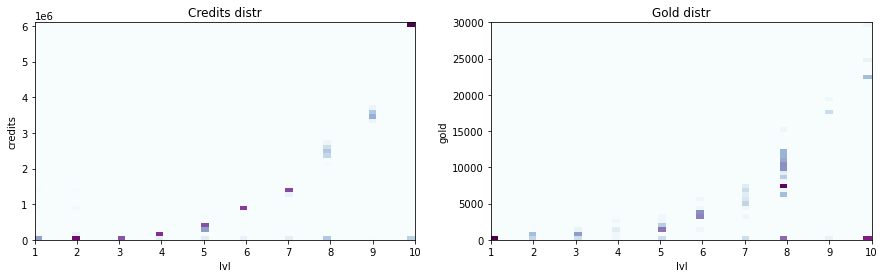

In [10]:
creds_catalog = catalog[catalog['item_price_gold'] == 0]
gold_catalog = catalog[catalog['item_price_credit'] == 0]

fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].hist2d(creds_catalog['item_level'], creds_catalog['item_price_credit'], bins=(50, 50), cmap=plt.cm.BuPu)
axs[0].set_title('Credits distr')
axs[0].set_xlabel('lvl')
axs[0].set_ylabel('credits')

axs[1].hist2d(gold_catalog['item_level'], gold_catalog['item_price_gold'], bins=(50, 50), cmap=plt.cm.BuPu)
axs[1].set_title('Gold distr')
axs[1].set_xlabel('lvl')
axs[1].set_ylabel('gold')

plt.show()